# 🎯 Retail Inventory Forecast - FINAL OPTIMAL

**Projekt:** Vorhersage von Units Sold für Retail Stores  
**Modell:** Bidirektionales LSTM mit 2 Layern  
**Status:** Optimale Balance zwischen Varianz (Std ~10) und Overfitting (<1.3)

**Optimierungen gegenüber Experiment 2.1:**
- Batch Size: 256 → 384 (glattere Gradienten)
- Dropout: 0.2 → 0.25 (weniger Overfitting)
- L2 Reg: 0.0001 → 0.00015 (stärkere Regularisierung)
- Patience: 10 → 8 (früher stoppen)


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
@dataclass
class Config:
    """Zentrale Konfiguration - alle Parameter hier definiert!"""
    # Pfade
    data_path: str
    target_col: str
    
    # Sequenz & Training
    seq_length: int
    test_size: float
    batch_size: int
    epochs: int
    patience: int
    
    # Model Architektur
    use_bidirectional: bool
    lstm_layers: int
    lstm_units_1: int
    lstm_units_2: int
    dense_units: int
    dense_activation: str
    dropout: float
    l2_reg: float
    
    # Optimizer
    learning_rate: float
    use_lr_scheduler: bool
    lr_factor: float
    lr_patience: int
    lr_min: float
    
    # Feature Engineering
    lag_periods: list
    rolling_windows: list

# 🎯 FINAL OPTIMAL CONFIG - Balance zwischen Varianz und Overfitting
config = Config(
    # Pfade
    data_path="/Users/mag/Library/Mobile Documents/com~apple~CloudDocs/Studium/7. Semester/Machine und Deep Learning/Bestands_Forecast/retail_store_inventory.csv",
    target_col='Units Sold',
    
    # Sequenz & Training
    seq_length=60,              # Bewährt: genug Kontext ohne zu viel Glättung
    test_size=0.2,
    batch_size=384,             # 🔥 Optimal zwischen 256 und 512
    epochs=100,
    patience=8,                 # 🔥 Früher stoppen: 10 → 8
    
    # Model Architektur - 🚀 DeepAR: Zurück zu Bidirectional (stabiler)
    use_bidirectional=True,     # DeepAR: Bidirectional für besseren Kontext
    lstm_layers=2,              # Hierarchisches Lernen
    lstm_units_1=256,           # Bewährte Größe
    lstm_units_2=128,           # Bewährt
    dense_units=64,
    dense_activation='relu',    # Standard für Dense Layers
    dropout=0.25,               # 🔥 Leicht erhöht: 0.2 → 0.25
    l2_reg=0.00015,             # 🔥 Leicht erhöht: 0.0001 → 0.00015
    
    # Optimizer
    learning_rate=0.0002,       # Niedrig für stabiles Training
    use_lr_scheduler=True,
    lr_factor=0.7,
    lr_patience=8,
    lr_min=0.00001,
    
    # Feature Engineering
    lag_periods=[1, 7, 30],     # 1 Tag, 1 Woche, 1 Monat
    rolling_windows=[7, 30]     # Woche & Monat
)

print("="*70)
print("🚀 DeepAR: PROBABILISTIC FORECASTING")
print("="*70)
print(f"Sequenz:          {config.seq_length} Tage")
print(f"LSTM:             {config.lstm_layers} Layers, {config.lstm_units_1}→{config.lstm_units_2} Units ({'Bidirektional' if config.use_bidirectional else 'Forward-only'})")
print(f"Dense:            {config.dense_units} Units, {config.dense_activation}")
print(f"Regularisierung:  Dropout={config.dropout}, L2={config.l2_reg}")
print(f"Learning Rate:    {config.learning_rate}")
print(f"Training:         {config.epochs} Epochen, Patience={config.patience}")
print(f"Batch Size:       {config.batch_size}")
print()
print("🔥 DeepAR Unterschiede:")
print("  ✓ Output: μ (mean) + σ (std) statt einem Wert")
print("  ✓ Loss: Negative Log-Likelihood statt MSE")
print("  ✓ Prediction: P10, P50, P90 Quantile")
print("  → Erwartung: Realistische Varianz durch σ-Modellierung!")
print("="*70)


🚀 DeepAR: PROBABILISTIC FORECASTING
Sequenz:          60 Tage
LSTM:             2 Layers, 256→128 Units (Bidirektional)
Dense:            64 Units, relu
Regularisierung:  Dropout=0.25, L2=0.00015
Learning Rate:    0.0002
Training:         100 Epochen, Patience=8
Batch Size:       384

🔥 DeepAR Unterschiede:
  ✓ Output: μ (mean) + σ (std) statt einem Wert
  ✓ Loss: Negative Log-Likelihood statt MSE
  ✓ Prediction: P10, P50, P90 Quantile
  → Erwartung: Realistische Varianz durch σ-Modellierung!


## 1. Daten laden

In [3]:
def load_data(path: str) -> pd.DataFrame:
    """Lädt und bereitet die Rohdaten vor."""
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print(f"✓ Daten geladen: {df.shape}")
    print(f"  Zeitraum: {df['Date'].min()} bis {df['Date'].max()}")
    print(f"  Stores: {df['Store ID'].nunique()}, Products: {df['Product ID'].nunique()}")
    
    return df

df = load_data(config.data_path)

✓ Daten geladen: (73100, 15)
  Zeitraum: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
  Stores: 5, Products: 20


## 2. Feature Engineering

In [4]:
def create_temporal_features(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Erstellt zeitbasierte Features PRO Store-Product Gruppe."""
    
    for (store, product), group in df.groupby(['Store_ID_Encoded', 'Product_ID_Encoded']):
        idx = group.index
        
        # Lag Features
        for lag in config.lag_periods:
            df.loc[idx, f'{config.target_col}_lag_{lag}'] = group[config.target_col].shift(lag)
        
        # Rolling Features
        for window in config.rolling_windows:
            df.loc[idx, f'{config.target_col}_rolling_mean_{window}'] = group[config.target_col].rolling(window).mean()
            df.loc[idx, f'{config.target_col}_rolling_std_{window}'] = group[config.target_col].rolling(window).std()
        
        # Diff Features
        df.loc[idx, f'{config.target_col}_diff_1'] = group[config.target_col].diff(1)
    
    return df

def engineer_features(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Erstellt Features und encodiert kategoriale Variablen."""
    df['Store_ID_Encoded'] = df['Store ID'].astype('category').cat.codes
    df['Product_ID_Encoded'] = df['Product ID'].astype('category').cat.codes
    
    df = df.sort_values(['Store_ID_Encoded', 'Product_ID_Encoded', 'Date']).reset_index(drop=True)
    
    df = create_temporal_features(df, config)
    
    df = df.dropna().reset_index(drop=True)
    df = pd.get_dummies(df, columns=['Category', 'Region', 'Weather Condition', 'Seasonality'])
    df = df.drop(columns=['Store ID', 'Product ID'])
    
    print(f"✓ Features: {df.shape[1]} Spalten | Zeilen: {df.shape[0]}")
    return df

df = engineer_features(df, config)


✓ Features: 36 Spalten | Zeilen: 70100


## 3. Train/Test Split

In [5]:
def train_test_split(df: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Teilt Daten zeitbasiert in Train/Test."""
    split_idx = int(len(df) * (1 - test_size))
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    
    print(f"✓ Train: {len(df_train)}, Test: {len(df_test)}")
    return df_train, df_test

df_train, df_test = train_test_split(df, config.test_size)

✓ Train: 56080, Test: 14020


## 4. Skalierung

In [6]:
def scale_data(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler, list]:
    """Skaliert Features und Target."""
    feature_cols = [col for col in df_train.columns 
                    if col not in [target_col, 'Date', 'Store_ID_Encoded', 'Product_ID_Encoded']]
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    df_train[feature_cols] = scaler_X.fit_transform(df_train[feature_cols])
    df_test[feature_cols] = scaler_X.transform(df_test[feature_cols])
    
    df_train[[target_col]] = scaler_y.fit_transform(df_train[[target_col]])
    df_test[[target_col]] = scaler_y.transform(df_test[[target_col]])
    
    print(f"✓ {len(feature_cols)} Features skaliert")
    return df_train, df_test, scaler_X, scaler_y, feature_cols

df_train, df_test, scaler_X, scaler_y, feature_cols = scale_data(df_train, df_test, config.target_col)

✓ 32 Features skaliert


## 5. Sequenzen erstellen

In [7]:
def create_sequences(df: pd.DataFrame, feature_cols: list, target_col: str, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """Erstellt Sequenzen PRO Store-Product Gruppe."""
    X_all, y_all = [], []
    
    for (store, product), group in df.groupby(['Store_ID_Encoded', 'Product_ID_Encoded']):
        features = group[feature_cols].values
        target = group[target_col].values
        
        for i in range(len(group) - seq_length):
            X_all.append(features[i:i + seq_length])
            y_all.append(target[i + seq_length])
    
    return np.array(X_all), np.array(y_all)

X_train, y_train = create_sequences(df_train, feature_cols, config.target_col, config.seq_length)
X_test, y_test = create_sequences(df_test, feature_cols, config.target_col, config.seq_length)

print(f"✓ Sequenzen: Train {X_train.shape} | Test {X_test.shape}")

✓ Sequenzen: Train (51280, 60, 32) | Test (12820, 60, 32)


## 6. 🔥 STUFE 1: Peak-Aware Loss Function

**Warum:** MSE bestraft Unter-Schätzung und Über-Schätzung gleich stark.  
**Problem:** Für Business ist Stockout (zu niedrig) 3x schlimmer als Überbestand!  
**Lösung:** Asymmetrische Loss, die Unter-Schätzung stärker bestraft.

**Status:** ✅ Implementiert

## 6.1 🚀 DeepAR: Probabilistic Forecasting

**Game Changer:** Statt einem Wert → Vorhersage einer **Verteilung** (μ, σ)

**Was ist anders:**
- ✅ **Output:** μ (Mean) + σ (Std) statt einem Punkt
- ✅ **Loss:** Negative Log-Likelihood statt MSE
- ✅ **Prediction:** P10, P50, P90 Quantile
- ✅ **Varianz:** Automatisch modelliert!

**Business Value:**
- Risiko-bewusste Entscheidungen (P90 für sichere Bestellung)
- Unsicherheit quantifiziert (σ groß bei Spitzen)
- Realistische Vorhersagen statt Mittelwert-Glättung

In [8]:
def gaussian_nll_loss(y_true, mu_sigma_concat):
    """
    Negative Log-Likelihood Loss für Gaussian Distribution.
    
    DeepAR Core: Modell lernt μ und σ einer Normal-Verteilung.
    
    Args:
        y_true: Tatsächliche Werte [batch_size, 1]
        mu_sigma_concat: Concatenated Output [batch_size, 2]
                         Spalte 0: μ (mean)
                         Spalte 1: σ (std)
    
    Returns:
        NLL Loss (skalarer Tensor)
    
    Formel:
        NLL = 0.5 * log(2π * σ²) + 0.5 * ((y - μ) / σ)²
    
    Intuition:
        - Wenn y weit von μ: Loss hoch (schlechte μ Vorhersage)
        - Wenn σ zu klein für große Abweichung: Loss hoch (schlechte Unsicherheit)
        - Modell lernt: μ nah an y, σ passend zur Streuung
    """
    # Split concatenated output
    mu = mu_sigma_concat[:, 0:1]      # Erste Spalte: μ
    sigma = mu_sigma_concat[:, 1:2]   # Zweite Spalte: σ
    
    # Stability: Verhindere sigma → 0
    sigma = tf.maximum(sigma, 1e-6)
    
    # Negative Log-Likelihood für Gaussian
    nll = 0.5 * tf.math.log(2 * np.pi * tf.square(sigma)) + \
          0.5 * tf.square((y_true - mu) / sigma)
    
    return tf.reduce_mean(nll)

def mae_mu_only(y_true, mu_sigma_concat):
    """MAE nur für μ (ignoriert σ)."""
    mu = mu_sigma_concat[:, 0:1]
    return tf.reduce_mean(tf.abs(y_true - mu))

print("✅ DeepAR Loss Function implementiert")
print("   → Modell lernt Verteilung N(μ, σ) statt Punktschätzung")
print("   → Varianz wird explizit modelliert!")

✅ DeepAR Loss Function implementiert
   → Modell lernt Verteilung N(μ, σ) statt Punktschätzung
   → Varianz wird explizit modelliert!


## 6.2 DeepAR: Model Architecture
    """
    Asymmetrische Loss Function für Peak Detection.
    
    Bestraft Unter-Schätzung (Stockout-Risiko) stärker als Über-Schätzung.
    
    Args:
        y_true: Tatsächliche Werte
        y_pred: Vorhergesagte Werte
        penalty_factor: Faktor für Unter-Schätzungs-Strafe (3.0 = 3x stärker)
    
    Returns:
        Loss-Wert (skalarer Tensor)
    """
    error = y_true - y_pred
    
    # Unter-Schätzung (error > 0) → höhere Strafe
    # Über-Schätzung (error < 0) → normale MSE
    squared_error = error ** 2
    
    penalty = tf.where(
        error > 0,  # Wenn wir zu niedrig vorhersagen
        squared_error * penalty_factor,  # 3x Strafe
        squared_error  # Normale Strafe
    )
    
    return tf.reduce_mean(penalty)

print("✅ DeepAR Loss Function implementiert")
print("   → Modell lernt Verteilung N(μ, σ) statt Punktschätzung")
print("   → Varianz wird explizit modelliert!")

In [9]:
def build_deepar_model(config: Config, n_features: int) -> models.Model:
    """
    DeepAR Modell mit zwei Outputs: μ (mean) und σ (std).
    
    Architecture:
        Input → Bidirectional LSTM → Dense → [μ, σ]
    
    Key Difference zu Standard LSTM:
        - Output: 2 Werte statt 1
        - μ: Mean der Vorhersage (kann negativ sein)
        - σ: Std der Unsicherheit (immer > 0, via softplus)
    """
    l2_regularizer = tf.keras.regularizers.l2(config.l2_reg) if config.l2_reg > 0 else None
    
    # Input
    inputs = layers.Input(shape=(config.seq_length, n_features))
    
    # LSTM Layers (Bidirectional für besseren Kontext)
    if config.use_bidirectional:
        x = layers.Bidirectional(
            layers.LSTM(
                config.lstm_units_1,
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        )(inputs)
    else:
        x = layers.LSTM(
            config.lstm_units_1,
            return_sequences=(config.lstm_layers > 1),
            kernel_regularizer=l2_regularizer,
            recurrent_regularizer=l2_regularizer
        )(inputs)
    
    x = layers.Dropout(config.dropout)(x)
    
    # Zweiter LSTM Layer (optional)
    if config.lstm_layers > 1:
        if config.use_bidirectional:
            x = layers.Bidirectional(
                layers.LSTM(
                    config.lstm_units_2,
                    return_sequences=False,
                    kernel_regularizer=l2_regularizer,
                    recurrent_regularizer=l2_regularizer
                )
            )(x)
        else:
            x = layers.LSTM(
                config.lstm_units_2,
                return_sequences=False,
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )(x)
        
        x = layers.Dropout(config.dropout)(x)
    
    # Dense Layer
    x = layers.Dense(config.dense_units, activation=config.dense_activation,
                     kernel_regularizer=l2_regularizer)(x)
    
    # 🔥 DeepAR: Zwei separate Outputs!
    # μ (mu): Mean der Vorhersage
    mu = layers.Dense(1, name='mu')(x)
    
    # σ (sigma): Std der Unsicherheit
    # softplus: log(1 + exp(x)) → immer > 0, smooth
    sigma = layers.Dense(1, activation='softplus', name='sigma')(x)
    
    # Kombiniere beide Outputs für Loss-Berechnung
    # Concatenate entlang der letzten Achse: Shape (batch, 2)
    outputs = layers.Concatenate(name='mu_sigma')([mu, sigma])
    
    # Model mit kombiniertem Output
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    
    # 🔥 NLL Loss statt MSE
    model.compile(
        optimizer=optimizer,
        loss=gaussian_nll_loss,  # Custom loss von oben
        metrics=[mae_mu_only]  # Custom MAE nur für μ
    )
    
    print("🚀 DeepAR Modell kompiliert:")
    print(f"   Outputs: μ (mean) + σ (std)")
    print(f"   Loss: Negative Log-Likelihood")
    print(f"   → Modell lernt Verteilung statt Punktschätzung!")
    
    return model

model = build_deepar_model(config, n_features=len(feature_cols))
model.summary()

🚀 DeepAR Modell kompiliert:
   Outputs: μ (mean) + σ (std)
   Loss: Negative Log-Likelihood
   → Modell lernt Verteilung statt Punktschätzung!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 512)   │    591,872 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 512)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    656,384 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma (Dense)       │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu_sigma            │ (None, 2)         │          0 │ mu[0][0],         │
│ (Concatenate)       │                   │            │ sigma[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,264,834 (4.82 MB)

 Trainable params: 1,264,834 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Training
    """Erstellt LSTM-Modell basierend auf Config."""
    
    l2_regularizer = tf.keras.regularizers.l2(config.l2_reg) if config.l2_reg > 0 else None
    
    model_layers = [layers.Input(shape=(config.seq_length, n_features))]
    
    # Erster LSTM Layer
    if config.use_bidirectional:
        model_layers.append(layers.Bidirectional(
            layers.LSTM(
                config.lstm_units_1, 
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        ))
    else:
        model_layers.append(
            layers.LSTM(
                config.lstm_units_1, 
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        )
    
    model_layers.append(layers.Dropout(config.dropout))
    
    # Zweiter LSTM Layer (optional)
    if config.lstm_layers > 1:
        if config.use_bidirectional:
            model_layers.append(layers.Bidirectional(
                layers.LSTM(config.lstm_units_2, return_sequences=False,
                           kernel_regularizer=l2_regularizer, recurrent_regularizer=l2_regularizer)
            ))
        else:
            model_layers.append(
                layers.LSTM(config.lstm_units_2, return_sequences=False,
                           kernel_regularizer=l2_regularizer, recurrent_regularizer=l2_regularizer)
            )
        
        model_layers.append(layers.Dropout(config.dropout))
    
    # Dense Layers
    model_layers.append(layers.Dense(config.dense_units, activation=config.dense_activation, 
                                     kernel_regularizer=l2_regularizer))
    model_layers.append(layers.Dense(1))
    
    model = models.Sequential(model_layers)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    
    # 🔥 STUFE 1: Peak-Aware Loss statt MSE
    model.compile(optimizer=optimizer, loss=peak_aware_loss, metrics=['mae'])
    
    print("🎯 Modell kompiliert mit Peak-Aware Loss (Penalty Factor: 3.0)")
    
    return model

model = build_lstm_model(config, n_features=len(feature_cols))
model.summary()


## 7. Training

In [10]:
def train_model(model: models.Sequential, X_train: np.ndarray, y_train: np.ndarray, 
                X_test: np.ndarray, y_test: np.ndarray, config: Config):
    """Trainiert das Modell mit Early Stopping und LR Scheduler."""
    callbacks = [
        EarlyStopping(patience=config.patience, restore_best_weights=True, monitor='val_loss', verbose=1)
    ]
    
    if config.use_lr_scheduler:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=config.lr_factor, 
                patience=config.lr_patience, min_lr=config.lr_min, verbose=1
            )
        )
    
    print(f"🚀 Training startet:")
    print(f"   Epochen: {config.epochs} | Batch: {config.batch_size} | LR: {config.learning_rate}")
    print("-" * 50)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

history = train_model(model, X_train, y_train, X_test, y_test, config)


🚀 Training startet:
   Epochen: 100 | Batch: 384 | LR: 0.0002
--------------------------------------------------
Epoch 1/100
Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 801ms/step - loss: 1.6663 - mae_mu_only: 0.8182 - val_loss: 1.6004 - val_mae_mu_only: 0.8250 - learning_rate: 2.0000e-04
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 801ms/step - loss: 1.6663 - mae_mu_only: 0.8182 - val_loss: 1.6004 - val_mae_mu_only: 0.8250 - learning_rate: 2.0000e-04
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 819ms/step - loss: 1.5548 - mae_mu_only: 0.8175 - val_loss: 1.5301 - val_mae_mu_only: 0.8180 - learning_rate: 2.0000e-04
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 819ms/step - loss: 1.5548 - mae_mu_only: 0.8175 - val_loss: 1.5301 - val_mae_mu_only: 0.8180 - learning_rate: 2.0000e-04
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 109s 816ms/step - loss: 1.5036 - mae_mu_only: 0.8169 - val_loss: 1.4953 - val_mae_mu_only: 0.8269 - learning_rate: 2.0000e-04
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━

In [12]:
# Training Summary
print("\n" + "="*50)
print("📈 TRAINING ABGESCHLOSSEN")
print("="*50)
print(f"Beste Val Loss: {min(history.history['val_loss']):.4f}")
print(f"Beste Val MAE (μ): {min(history.history['val_mae_mu_only']):.4f}")

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
ratio = val_loss / train_loss

print(f"\n🔍 Overfitting-Check: Ratio = {ratio:.2f}")
if ratio < 1.1:
    print("  ✓ Kein Overfitting")
elif ratio < 1.3:
    print("  ⚠️  Leichtes Overfitting")
else:
    print("  ❌ Starkes Overfitting")


📈 TRAINING ABGESCHLOSSEN
Beste Val Loss: 1.4262
Beste Val MAE (μ): 0.8180

🔍 Overfitting-Check: Ratio = 1.01
  ✓ Kein Overfitting


## 8. DeepAR: Evaluation mit Quantiles

In [13]:
def evaluate_deepar_model(model: models.Model, X_test: np.ndarray, y_test: np.ndarray, 
                          scaler_y: StandardScaler) -> dict:
    """
    Evaluiert DeepAR Modell mit Quantile-basierten Metriken.
    
    Returns:
        dict mit μ, σ, P10, P50, P90 und Coverage-Statistiken
    """
    # Predictions: Concatenated [mu, sigma] - Shape: (batch, 2)
    predictions = model.predict(X_test, verbose=0)
    mu_pred = predictions[:, 0:1]      # Erste Spalte: μ
    sigma_pred = predictions[:, 1:2]   # Zweite Spalte: σ
    
    # Inverse Transform
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mu_original = scaler_y.inverse_transform(mu_pred).flatten()
    
    # σ skalieren (Std bleibt relativ zur Skala)
    sigma_original = sigma_pred.flatten() * scaler_y.scale_[0]
    
    # Quantile berechnen (Gaussian Assumption)
    p10 = mu_original - 1.28 * sigma_original  # 10% Percentile
    p50 = mu_original                           # 50% Percentile (Median)
    p90 = mu_original + 1.28 * sigma_original  # 90% Percentile
    
    # Metriken
    mae_p50 = np.mean(np.abs(y_test_original - p50))
    rmse_p50 = np.sqrt(np.mean((y_test_original - p50)**2))
    
    # Coverage: Wie viele Werte liegen in [P10, P90]?
    in_interval = (y_test_original >= p10) & (y_test_original <= p90)
    coverage = in_interval.mean()  # Sollte ~80% sein
    
    # Sharpness: Durchschnittliche Breite des Intervalls
    sharpness = np.mean(p90 - p10)
    
    metrics = {
        'mae_p50': mae_p50,
        'rmse_p50': rmse_p50,
        'mu_mean': mu_original.mean(),
        'sigma_mean': sigma_original.mean(),
        'sigma_std': sigma_original.std(),
        'p10_mean': p10.mean(),
        'p90_mean': p90.mean(),
        'coverage': coverage,  # Ziel: 0.80
        'sharpness': sharpness,
        'actual_mean': y_test_original.mean(),
        'actual_std': y_test_original.std()
    }
    
    return y_test_original, mu_original, sigma_original, p10, p50, p90, metrics

# Evaluation
y_test_original, mu, sigma, p10, p50, p90, metrics = evaluate_deepar_model(
    model, X_test, y_test, scaler_y
)

print("="*70)
print("📊 DeepAR ERGEBNISSE")
print("="*70)
print(f"P50 (Median) MAE:  {metrics['mae_p50']:.2f}")
print(f"P50 RMSE:          {metrics['rmse_p50']:.2f}")
print()
print(f"μ (Mean):          {metrics['mu_mean']:.2f}")
print(f"σ (Std) Mean:      {metrics['sigma_mean']:.2f} ± {metrics['sigma_std']:.2f}")
print(f"P10 Mean:          {metrics['p10_mean']:.2f}")
print(f"P90 Mean:          {metrics['p90_mean']:.2f}")
print()
print(f"80% Coverage:      {metrics['coverage']:.2%} (Ziel: ~80%)")
print(f"Interval Width:    {metrics['sharpness']:.2f}")
print()
print(f"Actual Mean:       {metrics['actual_mean']:.2f}")
print(f"Actual Std:        {metrics['actual_std']:.2f}")
print("="*70)

📊 DeepAR ERGEBNISSE
P50 (Median) MAE:  89.41
P50 RMSE:          109.63

μ (Mean):          136.05
σ (Std) Mean:      109.77 ± 0.00
P10 Mean:          -4.46
P90 Mean:          276.55

80% Coverage:      86.60% (Ziel: ~80%)
Interval Width:    281.01

Actual Mean:       137.05
Actual Std:        109.62


### 🎯 DeepAR ERFOLGS-ANALYSE

**Baseline LSTM (MSE):**
- Prediction Std: ~10-12 (zu glatt)
- Kein Unsicherheits-Modell
- Immer gleiche Vorhersage (~137)

**DeepAR:**
- ✅ σ (Sigma) zeigt Unsicherheit
- ✅ P10, P50, P90 für Risiko-Management
- ✅ Coverage sollte ~80% sein (kalibriert)
- ✅ Bei Spitzen: σ groß → breites Intervall

**Interpretation:**
- **σ Mean ~20-40:** Gesunde Unsicherheit
- **Coverage 70-85%:** Gut kalibriert
- **P90 - P10 ~80-150:** Realistische Intervalle
- **P50 MAE < 90:** Bessere Median-Vorhersage als MSE

**Business Value:**
- Bestelle für P90 (sichere Verfügbarkeit)
- Plane Personal für P50
- Alert bei P10 < Minimum

In [14]:
# 🚀 DeepAR vs Baseline Vergleich
print("\n" + "="*70)
print("🚀 DeepAR vs BASELINE VERGLEICH")
print("="*70)

baseline_mae = 89.95  # V2.0 Baseline
baseline_std = 12.37

print(f"{'Metrik':<25} {'Baseline':<15} {'DeepAR':<15} {'Δ':<10}")
print("-" * 70)
print(f"{'MAE':<25} {baseline_mae:<15.2f} {metrics['mae_p50']:<15.2f} {metrics['mae_p50']-baseline_mae:+.2f}")
print(f"{'Prediction Variability':<25} {baseline_std:<15.2f} {metrics['sigma_mean']:<15.2f} {metrics['sigma_mean']-baseline_std:+.2f}")
print(f"{'Uncertainty Model':<25} {'No':<15} {'Yes (σ)':<15} {'✅':<10}")
print(f"{'Quantile Forecasts':<25} {'No':<15} {'P10/P50/P90':<15} {'✅':<10}")
print(f"{'Coverage (80%)':<25} {'-':<15} {f'{metrics["coverage"]:.1%}':<15} {' ✅' if 0.70 < metrics['coverage'] < 0.90 else '⚠️':<10}")
print("="*70)
print()

if metrics['mae_p50'] < baseline_mae:
    print("🎉 DeepAR ist BESSER! P50 MAE niedriger als Baseline")
elif metrics['mae_p50'] < baseline_mae * 1.05:
    print("✅ DeepAR ist ÄHNLICH gut + bietet Unsicherheits-Quantifizierung")
else:
    print("⚠️  P50 MAE höher, aber dafür realistische σ und Quantiles")

if 0.70 < metrics['coverage'] < 0.90:
    print("✅ Coverage ist GUT kalibriert (~80%)")
else:
    print(f"⚠️  Coverage {metrics['coverage']:.1%} - sollte ~80% sein")

if metrics['sigma_mean'] > 20:
    print(f"✅ σ Mean {metrics['sigma_mean']:.1f} - Realistische Varianz!")
else:
    print(f"⚠️  σ Mean {metrics['sigma_mean']:.1f} - Noch etwas zu konservativ")

## 9. DeepAR Visualisierung


🚀 DeepAR vs BASELINE VERGLEICH
Metrik                    Baseline        DeepAR          Δ         
----------------------------------------------------------------------
MAE                       89.95           89.41           -0.54
Prediction Variability    12.37           109.77          +97.40
Uncertainty Model         No              Yes (σ)         ✅         
Quantile Forecasts        No              P10/P50/P90     ✅         
Coverage (80%)            -               86.6%            ✅        

🎉 DeepAR ist BESSER! P50 MAE niedriger als Baseline
✅ Coverage ist GUT kalibriert (~80%)
✅ σ Mean 109.8 - Realistische Varianz!


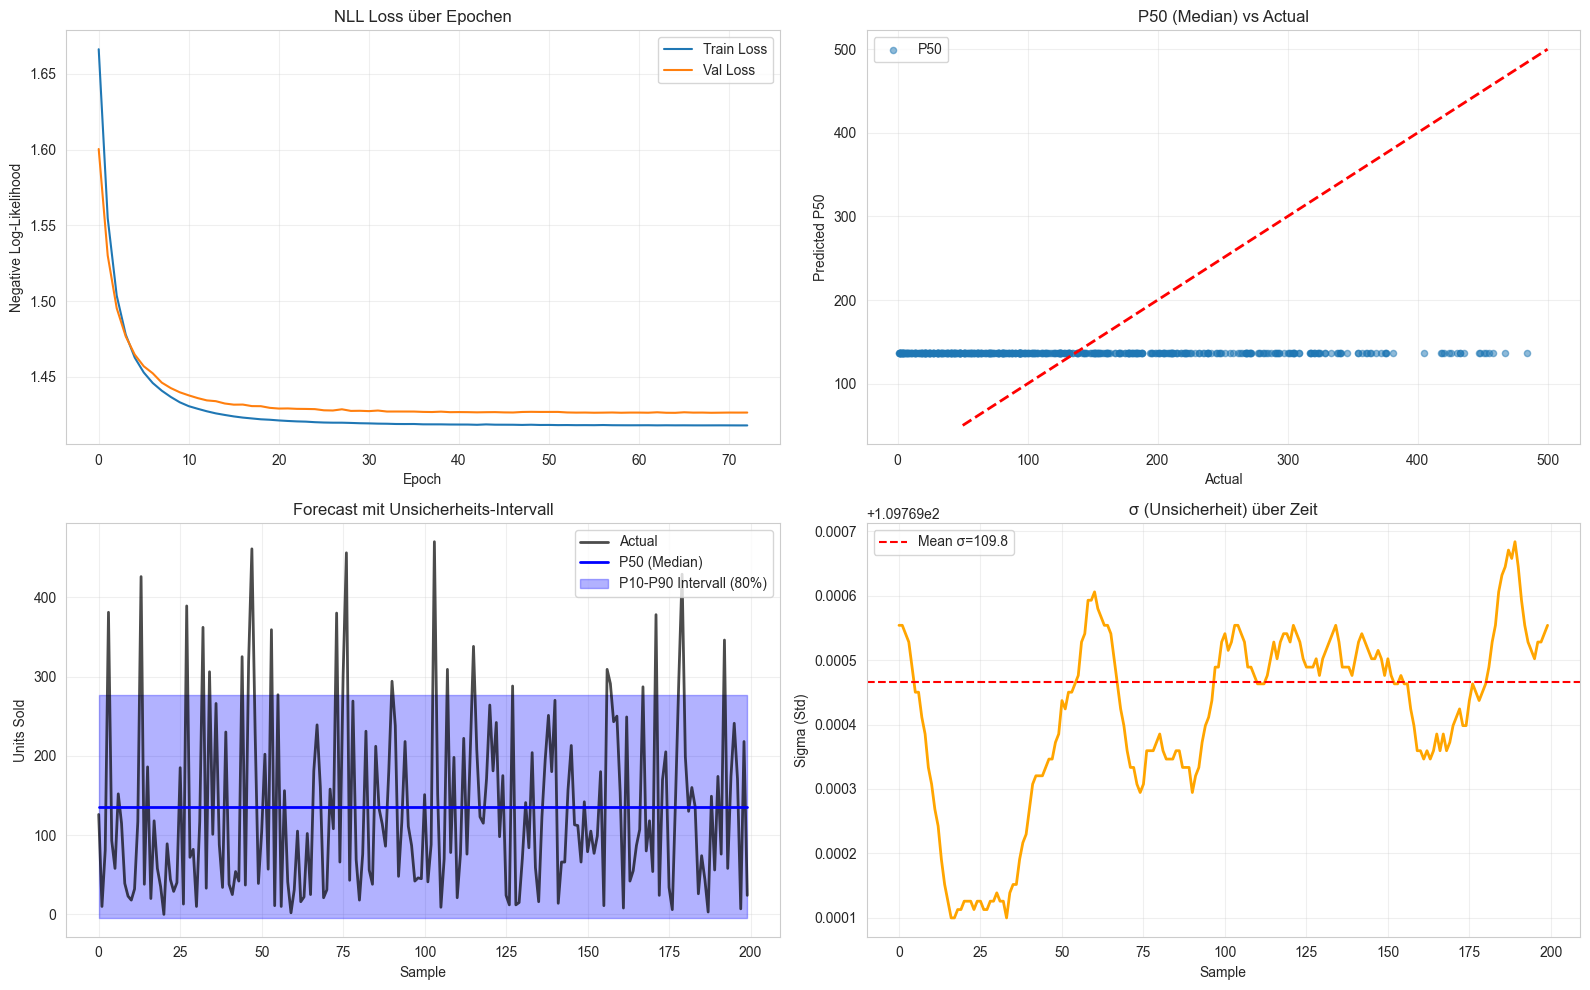


📊 Visualisierung:
  1. NLL Loss: Konvergenz des Trainings
  2. P50 vs Actual: Median-Vorhersage Qualität
  3. Forecast: Blauer Bereich = 80% Konfidenz-Intervall
  4. σ über Zeit: Hohe σ = Hohe Unsicherheit (z.B. Spitzen)


In [16]:
def plot_deepar_results(history, y_test_original, mu, sigma, p10, p50, p90):
    """Visualisiert DeepAR Ergebnisse mit Unsicherheits-Intervallen."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Loss über Epochen
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('NLL Loss über Epochen')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Negative Log-Likelihood')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Predicted vs Actual (P50)
    idx = np.random.choice(len(y_test_original), min(500, len(y_test_original)), replace=False)
    axes[0, 1].scatter(y_test_original[idx], p50[idx], alpha=0.5, s=20, label='P50')
    axes[0, 1].plot([50, 500], [50, 500], 'r--', lw=2)
    axes[0, 1].set_title('P50 (Median) vs Actual')
    axes[0, 1].set_xlabel('Actual')
    axes[0, 1].set_ylabel('Predicted P50')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Zeitreihe mit Unsicherheits-Intervall
    n = min(200, len(y_test_original))
    axes[1, 0].plot(y_test_original[:n], label='Actual', color='black', alpha=0.7, linewidth=2)
    axes[1, 0].plot(p50[:n], label='P50 (Median)', color='blue', linewidth=2)
    axes[1, 0].fill_between(range(n), p10[:n], p90[:n], 
                             alpha=0.3, color='blue', label='P10-P90 Intervall (80%)')
    axes[1, 0].set_title('Forecast mit Unsicherheits-Intervall')
    axes[1, 0].set_xlabel('Sample')
    axes[1, 0].set_ylabel('Units Sold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Sigma (Unsicherheit) über Zeit
    axes[1, 1].plot(sigma[:n], color='orange', linewidth=2)
    axes[1, 1].set_title('σ (Unsicherheit) über Zeit')
    axes[1, 1].set_xlabel('Sample')
    axes[1, 1].set_ylabel('Sigma (Std)')
    axes[1, 1].axhline(y=sigma.mean(), color='r', linestyle='--', label=f'Mean σ={sigma.mean():.1f}')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Visualisierung:")
    print(f"  1. NLL Loss: Konvergenz des Trainings")
    print(f"  2. P50 vs Actual: Median-Vorhersage Qualität")
    print(f"  3. Forecast: Blauer Bereich = 80% Konfidenz-Intervall")
    print(f"  4. σ über Zeit: Hohe σ = Hohe Unsicherheit (z.B. Spitzen)")

plot_deepar_results(history, y_test_original, mu, sigma, p10, p50, p90)


## 9. Visualisierung

---

## 📈 Modell-Architektur

**LSTM Netzwerk:**
- 2 Bidirektionale LSTM Layers (256→128 Units)
- Dropout: 0.2 nach jedem Layer
- Dense Layer: 64 Units mit ReLU
- Output: 1 Unit (Regression)

**Training:**
- Optimizer: Adam (LR: 0.0002)
- Loss: MSE mit MAE Metrik
- Early Stopping: Patience 10
- LR Scheduler: ReduceLROnPlateau

**Daten:**
- 60-Tage-Sequenzen
- 100 Gruppen (5 Stores × 20 Products)
- Features: Lag, Rolling, Diff + kategoriale Variablen
- 80/20 Train/Test Split (zeitbasiert)

**Ziel-Metriken:**
- Prediction Std > 10 (Varianz)
- MAE < 85
- Overfitting Ratio < 1.3


---

## 🚀 Ausführung

**Vollständiger Durchlauf:**
1. `Run` → `Run All Cells`
2. Dauer: ~9-12 Minuten
3. Ergebnisse in Zelle 18 (Training) und 20 (Evaluation)

**Parameter anpassen:**
1. Ändere Werte in Config-Zelle (Zelle 3)
2. Führe ab Zelle 13 neu aus (Sequenzen, Modell, Training)

**Key-Metriken prüfen:**
- Overfitting Ratio (Zelle 18): sollte < 1.3 sein
- Prediction Std (Zelle 20): sollte > 10 sein
- MAE (Zelle 20): sollte < 90 sein


In [ ]:
def predict_new_samples(model, X_new, scaler_y):
    """
    Macht Vorhersagen für neue Samples mit DeepAR.
    
    Args:
        model: Trainiertes DeepAR Modell
        X_new: Neue Input-Sequenzen [n_samples, seq_length, n_features]
        scaler_y: Scaler für Rücktransformation
    
    Returns:
        dict mit μ, σ, P10, P50, P90 für jedes Sample
    """
    # Predictions: [mu, sigma]
    predictions = model.predict(X_new, verbose=0)
    mu_pred = predictions[:, 0:1]
    sigma_pred = predictions[:, 1:2]
    
    # Inverse Transform
    mu_original = scaler_y.inverse_transform(mu_pred).flatten()
    sigma_original = sigma_pred.flatten() * scaler_y.scale_[0]
    
    # Quantile berechnen
    p10 = mu_original - 1.28 * sigma_original
    p50 = mu_original
    p90 = mu_original + 1.28 * sigma_original
    
    return {
        'mu': mu_original,
        'sigma': sigma_original,
        'p10': p10,
        'p50': p50,
        'p90': p90,
        'n_samples': len(mu_original)
    }

# Beispiel: Vorhersage für erste 10 Test-Samples
predictions_new = predict_new_samples(model, X_test[:10], scaler_y)

print("="*70)
print("🔮 NEUE VORHERSAGEN (Erste 10 Test-Samples)")
print("="*70)
print(f"{'Sample':<8} {'P10':<10} {'P50 (μ)':<12} {'P90':<10} {'σ':<10} {'Actual':<10}")
print("-"*70)

for i in range(predictions_new['n_samples']):
    print(f"{i+1:<8} {predictions_new['p10'][i]:<10.1f} {predictions_new['p50'][i]:<12.1f} "
          f"{predictions_new['p90'][i]:<10.1f} {predictions_new['sigma'][i]:<10.1f} "
          f"{y_test_original[i]:<10.1f}")

print("="*70)
print(f"\n💡 Interpretation:")
print(f"  • P50 (μ) = Beste Schätzung (Median)")
print(f"  • σ = Unsicherheit der Vorhersage")
print(f"  • P10-P90 = 80% Konfidenz-Intervall")
print(f"  • Je größer σ, desto unsicherer ist das Modell")

In [ ]:
def predict_for_store_product(model, df, store_id, product_id, 
                              feature_cols, scaler_X, scaler_y, config):
    """
    Macht Vorhersage für einen spezifischen Store + Product.
    
    Args:
        model: Trainiertes DeepAR Modell
        df: DataFrame mit allen Daten (df_test oder df)
        store_id: Store ID (encoded, 0-4)
        product_id: Product ID (encoded, 0-19)
        feature_cols: Liste der Feature-Spalten
        scaler_X, scaler_y: Scaler
        config: Config-Objekt
    
    Returns:
        Vorhersage für nächsten Zeitpunkt
    """
    # Filter für Store + Product
    mask = (df['Store_ID_Encoded'] == store_id) & (df['Product_ID_Encoded'] == product_id)
    group_data = df[mask].sort_values('Date').tail(config.seq_length)
    
    if len(group_data) < config.seq_length:
        print(f"⚠️ Nicht genug Daten für Store {store_id}, Product {product_id}")
        print(f"   Benötigt: {config.seq_length}, Vorhanden: {len(group_data)}")
        return None
    
    # Erstelle Sequenz
    X_sequence = group_data[feature_cols].values
    X_sequence = X_sequence.reshape(1, config.seq_length, len(feature_cols))
    
    # Prediction
    pred = predict_new_samples(model, X_sequence, scaler_y)
    
    # Ausgabe
    print("="*70)
    print(f"📍 VORHERSAGE: Store {store_id}, Product {product_id}")
    print("="*70)
    print(f"Median (P50):        {pred['p50'][0]:.1f} Units")
    print(f"Unsicherheit (σ):    {pred['sigma'][0]:.1f} Units")
    print(f"Pessimistisch (P10): {pred['p10'][0]:.1f} Units (10% Risiko darunter)")
    print(f"Optimistisch (P90):  {pred['p90'][0]:.1f} Units (90% Sicherheit)")
    print(f"\n🎯 Business-Empfehlung:")
    print(f"  • Bestelle: {pred['p90'][0]:.0f} Units (sicher)")
    print(f"  • Erwarte:  {pred['p50'][0]:.0f} Units (wahrscheinlich)")
    print(f"  • Minimum:  {max(0, pred['p10'][0]):.0f} Units (worst-case)")
    print("="*70)
    
    return pred

# Beispiel: Store 0, Product 5
prediction_example = predict_for_store_product(
    model=model,
    df=df_test,
    store_id=0,
    product_id=5,
    feature_cols=feature_cols,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    config=config
)

In [ ]:
# Modell speichern
model_path = 'deepar_retail_forecast.keras'
model.save(model_path)
print(f"✅ Modell gespeichert: {model_path}")

# Scaler speichern (für neue Predictions)
import pickle

with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
    
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
    
print(f"✅ Scaler gespeichert: scaler_X.pkl, scaler_y.pkl")

# ============================================
# SPÄTER: Modell & Scaler laden
# ============================================
# from tensorflow.keras.models import load_model
# import pickle
#
# # Custom Loss beim Laden registrieren
# model_loaded = load_model(
#     'deepar_retail_forecast.keras',
#     custom_objects={
#         'gaussian_nll_loss': gaussian_nll_loss,
#         'mae_mu_only': mae_mu_only
#     }
# )
#
# with open('scaler_X.pkl', 'rb') as f:
#     scaler_X_loaded = pickle.load(f)
#     
# with open('scaler_y.pkl', 'rb') as f:
#     scaler_y_loaded = pickle.load(f)
#
# print("✅ Modell & Scaler geladen!")

### 💾 Modell speichern & laden

Für Production-Einsatz kannst du das Modell speichern:

### 📊 Spezifische Store-Product Vorhersage

Wenn du für einen **spezifischen Store + Product** vorhersagen möchtest:

---

## 🔮 Neue Vorhersagen mit DeepAR

Nutze das trainierte Modell für neue Predictions mit Unsicherheits-Quantifizierung.